# Seattle Housing Prices - Predictive Modeling

### Workflow:

1. Feature Engineering
    - (a) Create dummy variables
    - (b) Adjusting year_renovated column as categorical (yes or no) rather than by date
    - (c) Drop sqft_lot and sqft_lot15
    
    
2. Create Train_Test_Split


3. Run baseline model
    - print RMSE


4. Iterate on model:
    - (a) Remove outliers
    - (b) Remove collinear variables
    - (c) Log transformations
    - (d) Drop non-sig p-values
    - (e) Unit Vectorization (update x-columns to add in unit vectors composed of collinear variables)
    
 

### Plan so far...

#### Dependent Variable:

    - Price

#### Explanatory Variables:

    - Keep: ['bedrooms',
             'bathrooms',
             'sqft_living',
             'floors',
             'sqft_above',
             'sqft_basement',
             'sqft_living15',
             'view',
             'waterfront',
             'yr_built]
    
    - Drop: ['sqft_lot', 'sqft_lot15']
    
    - Create dummies: ['condition', 'zipcode', 'grade']
    
    - Convert to binary: ['yr_renovated']
    
    - Will have to think of a plan for latitude and longitude

In [330]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

#### Import and drop columns:

In [331]:
house_data = pd.read_csv('house_data_cleaned.csv')
house_data.drop(['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)
house_data.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
0,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800


In [332]:
# 17 columns going on 97...
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
dtypes: float64(9), int64(8)
memory usage: 2.8 MB


#### Create dummy variables:

In [333]:
# Create a binary renovated column to determine whether the home was renovated or not
# Since the year renovated is not actionable unless we specialize in selling renovated homes from specific years
# but this way we can determine whether we should focus on renovations or not
house_data['yr_renovated'] = house_data.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
house_data.rename(columns = {"yr_renovated":"renovated"}, inplace=True)

In [334]:
# Drop first variable so they do not reference one another
cond_dum = pd.get_dummies(house_data['condition'], prefix='cond_', drop_first=True)
grade_dum = pd.get_dummies(house_data['grade'], prefix='grade_', drop_first=True)
zipcode_dum = pd.get_dummies(house_data['zipcode'], prefix='zipcode_', drop_first=True)
zipcode_dum.head()

,zipcode__98002,zipcode__98003,zipcode__98004,zipcode__98005,zipcode__98006,zipcode__98007,zipcode__98008,zipcode__98010,zipcode__98011,zipcode__98014,...,zipcode__98146,zipcode__98148,zipcode__98155,zipcode__98166,zipcode__98168,zipcode__98177,zipcode__98178,zipcode__98188,zipcode__98198,zipcode__98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [335]:
# Now to merge dummy columns onto our dataframe
upHouse_data = pd.concat([house_data, cond_dum, grade_dum, zipcode_dum], axis=1)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 100 columns):
price             21597 non-null float64
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null int64
grade             21597 non-null int64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null float64
yr_built          21597 non-null int64
renovated         21597 non-null int64
zipcode           21597 non-null int64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
cond__2           21597 non-null uint8
cond__3           21597 non-null uint8
cond__4           21597 non-null uint8
cond__5           21597 non-null uint8
grade__4          21597 non-null uint8
grade__5        

In [336]:
# Dropping un-dummied columns
upHouse_data.drop(columns=['condition', 'zipcode', 'grade'], inplace=True)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 97 columns):
price             21597 non-null float64
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null float64
yr_built          21597 non-null int64
renovated         21597 non-null int64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
cond__2           21597 non-null uint8
cond__3           21597 non-null uint8
cond__4           21597 non-null uint8
cond__5           21597 non-null uint8
grade__4          21597 non-null uint8
grade__5          21597 non-null uint8
grade__6          21597 non-null uint8
grade__7          21597 non-null uint8
grade__8         

### Now Train-Test-Split

... in preparation for our baseline model

In [337]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(upHouse_data.columns)
feat_cols.remove(outcome)

In [338]:
X = upHouse_data[feat_cols]
y = upHouse_data['price']

In [339]:
# Initial test-size of 70%

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,bedrooms,bathrooms,sqft_living,floors,waterfront,view,sqft_above,sqft_basement,yr_built,renovated,...,zipcode__98146,zipcode__98148,zipcode__98155,zipcode__98166,zipcode__98168,zipcode__98177,zipcode__98178,zipcode__98188,zipcode__98198,zipcode__98199
4900,3,1.00,1200,1.0,0.0,0.0,1200,0.0,1969,0,...,0,0,0,0,0,0,0,0,0,0
19664,3,2.50,1920,1.0,0.0,0.0,1920,0.0,2014,0,...,0,0,0,0,0,0,0,0,0,0
13949,3,1.75,1590,1.5,0.0,0.0,1590,0.0,1926,0,...,0,0,0,0,0,0,0,0,0,0
15272,4,4.00,2530,3.0,0.0,2.0,2100,430.0,2013,0,...,0,0,0,0,0,0,0,0,0,0
14411,3,2.50,2010,2.0,0.0,0.0,1390,620.0,2014,0,...,0,0,0,0,0,0,0,0,0,0


In [341]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

C:\Users\murra\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Vanilla Model

#### Side Note: Model Function

In [342]:
# I don't need those predictors/formulas
def training_model(predictor_cols, outcome, y_train, X_train):
    predictors = '+'.join(predictor_cols)
    formula = outcome + '~' + predictors
    model_vanilla = sm.OLS(y_train, X_train).fit()
    return model_vanilla.summary()

In [343]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     783.8
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:34:17   Log-Likelihood:            -2.0141e+05
No. Observations:               15117   AIC:                         4.030e+05
Df Residuals:                   15020   BIC:                         4.038e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.308e+07   6.73e+06     -4.915      0.000   -4.63e+07   -1.99e+07
bedrooms       -1.139e+04   1696.973     -6.712      0.000   -1.47e+04   -8062.984
bathrooms        1.99e+04   2918.057      6.819      0.000    1.42e+04    2.56e+04
sqft_living       85.2973     15.316      5.569      0.000      55.277     115.318
floors         -2.728e+04   3535.648     -7.715      0.000   -3.42e+04   -2.03e+04
waterfront      6.679e+05   1.59e+04     42.105      0.000    6.37e+05    6.99e+05
view             5.53e+04   1909.117     28.966      0.000    5.16e+04     5.9e+04
sqft_above        80.3272     15.394      5.218      0.000      50.152     110.502
sqft_basement     32.4125     15.167      2.137      0.033       2.684      62.141
yr_built        -278.9553     72.601     -3.842      0.000    -421.263    -136.648
renovated       5.188e+04   7097.815      7.309      0.000     3.8e+04    6.58e+04
lat              2.13e+05   7.03e+04      3.030      0.002    7.52e+04    3.51e+05
long           -1.928e+05   4.95e+04     -3.897      0.000    -2.9e+05   -9.58e+04
sqft_living15     14.2867      3.225      4.430      0.000       7.965      20.608
cond__2         7.923e+04   3.62e+04      2.188      0.029    8265.549     1.5e+05
cond__3         6.844e+04   3.36e+04      2.035      0.042    2528.473    1.34e+05
cond__4         9.203e+04   3.36e+04      2.736      0.006    2.61e+04    1.58e+05
cond__5         1.414e+05   3.38e+04      4.179      0.000    7.51e+04    2.08e+05
grade__4       -1.097e+05   1.53e+05     -0.718      0.473   -4.09e+05     1.9e+05
grade__5       -1.297e+05   1.49e+05     -0.868      0.385   -4.23e+05    1.63e+05
grade__6       -1.332e+05   1.49e+05     -0.894      0.371   -4.25e+05    1.59e+05
grade__7       -1.286e+05   1.49e+05     -0.863      0.388   -4.21e+05    1.63e+05
grade__8       -1.067e+05   1.49e+05     -0.716      0.474   -3.99e+05    1.85e+05
grade__9       -3.002e+04   1.49e+05     -0.201      0.841   -3.22e+05    2.62e+05
grade__10       8.848e+04   1.49e+05      0.593      0.553   -2.04e+05    3.81e+05
grade__11       3.109e+05    1.5e+05      2.078      0.038    1.76e+04    6.04e+05
grade__12       7.684e+05   1.51e+05      5.093      0.000    4.73e+05    1.06e+06
grade__13       1.165e+06   1.59e+05      7.337      0.000    8.54e+05    1.48e+06
zipcode__98002  1.802e+04   1.59e+04      1.136      0.256   -1.31e+04    4.91e+04
zipcode__98003 -9189.1622   1.42e+04     -0.645      0.519   -3.71e+04    1.87e+04
zipcode__98004  7.374e+05    2.6e+04     28.318      0.000    6.86e+05    7.88e+05
zipcode__98005  2.672e+05   2.77e+04      9.644      0.000    2.13e+05    3.22e+05
zipcode__98006  2.208e+05   2.26e+04      9.764      0.000    1.77e+05    2.65e+05
zipcode__98007  2.131e+05   2.84e+04      7.503      0.000    1.57e+05    2.69e+05
zipcode__980

In [344]:
# We see a very high R-squared and large standard errors, likely because of collinearity
# During our EDA, we noted there were several collinear variable pairs to be addressed

With our QQ plot for the vanilla model above, we can see that the graph is not normal with heavy skew on both low and high ends. The upper end has a greater skew showing there are likely a large number of outliers on this end.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. If we were doing so, we would have to narrow our data set to these alone.

In [345]:
model_vanilla = sm.OLS(y_train, X_train).fit()

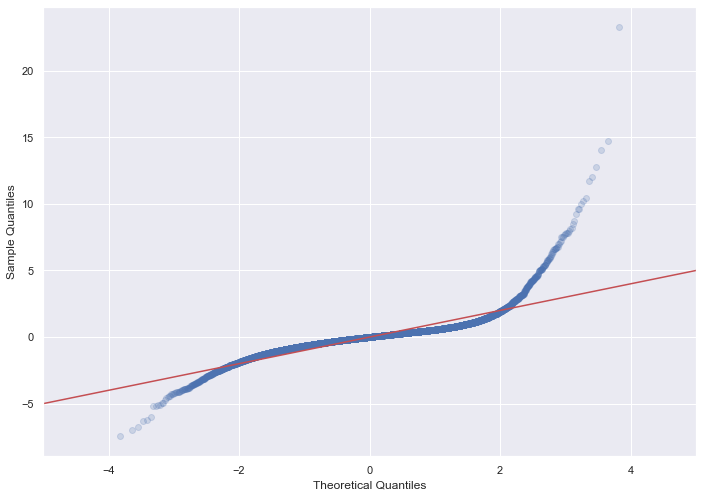

In [346]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_vanilla.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [347]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_vanilla.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_vanilla.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))


Train RMSE: 147910.53759775462 
 Test RMSE: 157970.48914322423
Percent change:  6.801


In [348]:
# Our test model is actually not far off, especially for the vanilla model.
# That being said, RMSE seems high. I think we can bring this down...
# especially by removing outliers and collinearity

### Model 2: Removing Outliers

In [349]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [350]:
# Going to remove outliers based on 2 standard deviations (95%)
# This is because our business focus is not on the most expensive or the cheapest homes.
# So in order to improve our model's prediction for relevant prices, we'll narrow our scope
# Down the line, I'd like to look at zipcodes and schools/bus stop data to see if that correlates with price
# If so, maybe we focus on those homes.
# Otherwise, let's see how renovations predicts pricing

Based on the results below for standard deviation of pricing, it would be inaccurate to filter our training and testing sets based on their own respective standard deviation since they will differ.

Therefore, to maintain consistency without training the original training set, we will filter both training and testing data based on 2 standard deviations from the mean from the overall dataset. This is effectively the same results as removing the pricing outliers before train_test_split.

In [351]:
print(y_train.std())
upHouse_data.price.std()

362615.56440877233


367368.1401013945

In [352]:
upHouse_data.price.std()

367368.1401013945

In [353]:
# Here is our code for filtering the training set based on 2 std from full dataset
# We can see the before and after to verify that outliers have been trimmed
mean_price = np.mean(upHouse_data.price, axis=0)
sd_price = np.std(upHouse_data.price, axis=0)

final_y_train_list = [y for y in y_train if (y > mean_price - 2 * sd_price)]
final_y_train_list = [y for y in final_y_train_list if (y < mean_price + 2 * sd_price)]
y_train_2std = pd.Series(final_y_train_list)

#### Comparison of y_train set before and after filtering for 2 standard deviations for price from the full dataset:

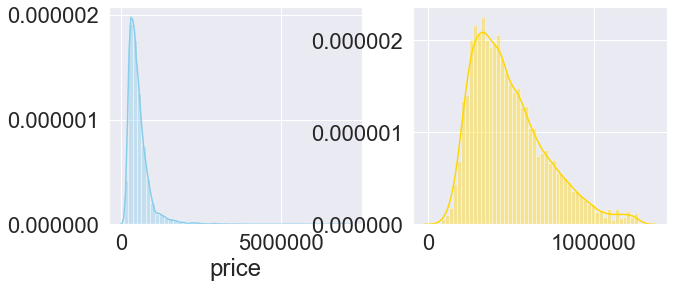

In [354]:
sns.set(font_scale=2) 
f, axes = plt.subplots(1, 2, figsize=(10,4));
sns.distplot(y_train, color="skyblue", ax=axes[0])
sns.distplot(y_train_2std, color="gold", ax=axes[1]);

In [355]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(upHouse_data.columns)
feat_cols.remove(outcome)

In [356]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
# Practicing on dataset. Will then apply to our y_train/y_test data 
upHouse_data_2std = upHouse_data[(np.abs(stats.zscore(upHouse_data.price)) < 2)]

# How many rows were removed & how many rows are left
print(len(upHouse_data.index.difference(upHouse_data_2std.index)))
len(upHouse_data_2std)

841


20756

In [357]:
X_out = upHouse_data_2std[feat_cols]
y_out = upHouse_data_2std['price']

In [358]:
len(y_out)

20756

In [359]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size = 0.30, random_state = 117)

In [360]:
# Add constants
X_train_out = sm.add_constant(X_train_out)
X_test_out = sm.add_constant(X_test_out)

C:\Users\murra\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [361]:
training_model(feat_cols, outcome, y_train_out, X_train_out)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     779.4
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:34:24   Log-Likelihood:            -1.8645e+05
No. Observations:               14529   AIC:                         3.731e+05
Df Residuals:                   14433   BIC:                         3.738e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.214e+07   4.24e+06     -2.864      0.004   -2.05e+07   -3.83e+06
bedrooms       -2403.1448   1075.266     -2.235      0.025   -4510.804    -295.486
bathrooms       1.479e+04   1874.020      7.891      0.000    1.11e+04    1.85e+04
sqft_living       45.1340     10.304      4.380      0.000      24.936      65.332
floors         -1.899e+04   2237.616     -8.486      0.000   -2.34e+04   -1.46e+04
waterfront      1.926e+05    1.5e+04     12.828      0.000    1.63e+05    2.22e+05
view            3.679e+04   1285.732     28.618      0.000    3.43e+04    3.93e+04
sqft_above        70.5100     10.323      6.831      0.000      50.276      90.744
sqft_basement     27.1278     10.205      2.658      0.008       7.125      47.131
yr_built        -416.0974     45.858     -9.074      0.000    -505.986    -326.209
renovated       4.002e+04   4661.745      8.584      0.000    3.09e+04    4.92e+04
lat              1.94e+05   4.36e+04      4.449      0.000    1.09e+05    2.79e+05
long           -3.097e+04   3.14e+04     -0.987      0.324   -9.25e+04    3.05e+04
sqft_living15     33.1205      2.138     15.489      0.000      28.929      37.312
cond__2         6.608e+04   2.22e+04      2.983      0.003    2.27e+04     1.1e+05
cond__3         8.132e+04   2.07e+04      3.938      0.000    4.08e+04    1.22e+05
cond__4          1.03e+05   2.07e+04      4.982      0.000    6.24e+04    1.43e+05
cond__5         1.369e+05   2.08e+04      6.582      0.000    9.61e+04    1.78e+05
grade__4       -1.225e+05   9.38e+04     -1.305      0.192   -3.06e+05    6.15e+04
grade__5       -1.278e+05   9.15e+04     -1.397      0.162   -3.07e+05    5.15e+04
grade__6       -1.212e+05   9.12e+04     -1.328      0.184      -3e+05    5.76e+04
grade__7       -9.631e+04   9.12e+04     -1.056      0.291   -2.75e+05    8.25e+04
grade__8       -5.575e+04   9.13e+04     -0.611      0.541   -2.35e+05    1.23e+05
grade__9        1.785e+04   9.13e+04      0.195      0.845   -1.61e+05    1.97e+05
grade__10       6.991e+04   9.14e+04      0.765      0.445   -1.09e+05    2.49e+05
grade__11       1.442e+05   9.18e+04      1.571      0.116   -3.57e+04    3.24e+05
grade__12       1.776e+05      1e+05      1.773      0.076   -1.87e+04    3.74e+05
grade__13       1.455e-09   1.35e-09      1.078      0.281   -1.19e-09     4.1e-09
zipcode__98002  8019.3195   9892.769      0.811      0.418   -1.14e+04    2.74e+04
zipcode__98003 -8393.5440   8803.251     -0.953      0.340   -2.56e+04    8861.959
zipcode__98004  4.783e+05   1.68e+04     28.480      0.000    4.45e+05    5.11e+05
zipcode__98005  2.828e+05   1.71e+04     16.551      0.000    2.49e+05    3.16e+05
zipcode__98006  2.247e+05   1.41e+04     15.952      0.000    1.97e+05    2.52e+05
zipcode__98007   2.06e+05   1.77e+04     11.606      0.000    1.71e+05    2.41e+05
zipcode__980

In [362]:
model2_out = sm.OLS(y_train_out, X_train_out).fit()

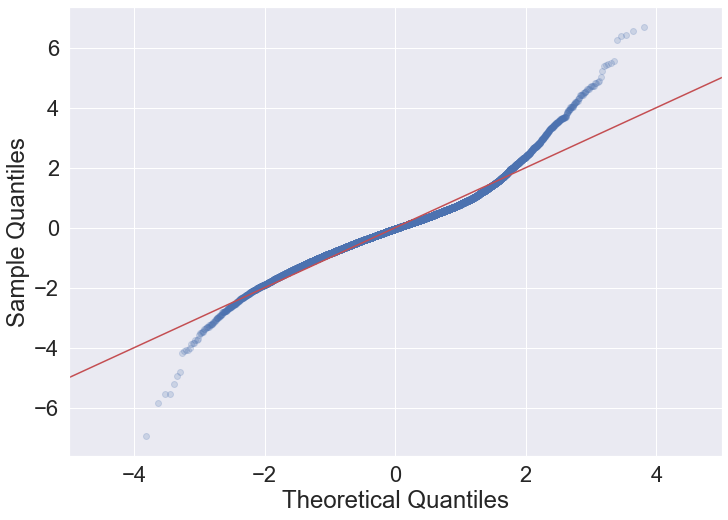

In [363]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model2_out.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [364]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train2 = model2_out.predict(X_train_out)
rmse_train2 = mse(y_train_out, y_hat_train2)**0.5
y_hat_test2 = model2_out.predict(X_test_out)
rmse_test2 = mse(y_test_out, y_hat_test2)**0.5
print(f'Train RMSE: {rmse_train2} \n Test RMSE: {rmse_test2}')
print('Percent change: ', round(((rmse_test2-rmse_train2)/rmse_train2)*100, 3))
print('Percent change (Test sets Base Model vs. Model2): ', round(((rmse_test2-rmse_test)/rmse_test)*100, 3))


Train RMSE: 90576.33526620908 
 Test RMSE: 90531.34574657946
Percent change:  -0.05
Percent change (Test sets Base Model vs. Model2):  -42.691


Adjusted R-squared improved by .003 to .836

RMSE decreased by 42.691% showing significant error reduction

### Model 3: Log Transformation to Price (y-variable)


In [365]:
# Transform y_train_out and y_test_out with np.log
y_train_log = np.log(y_train_out)
y_test_log = np.log(y_test_out)
# Check that Model 2 and Model 3's y variables match
print(len(y_train_log), len(y_train_out))

14529 14529


In [366]:
training_model(feat_cols, outcome, y_train_log, X_train_out)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     841.9
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:34:26   Log-Likelihood:                 4398.3
No. Observations:               14529   AIC:                            -8605.
Df Residuals:                   14433   BIC:                            -7877.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -39.3516      8.367     -4.703      0.000     -55.753     -22.950
bedrooms          -0.0031      0.002     -1.469      0.142      -0.007       0.001
bathrooms          0.0353      0.004      9.537      0.000       0.028       0.043
sqft_living        0.0001   2.03e-05      5.297      0.000    6.79e-05       0.000
floors            -0.0382      0.004     -8.641      0.000      -0.047      -0.030
waterfront         0.3752      0.030     12.663      0.000       0.317       0.433
view               0.0572      0.003     22.525      0.000       0.052       0.062
sqft_above         0.0001   2.04e-05      5.793      0.000    7.81e-05       0.000
sqft_basement    3.17e-05   2.01e-05      1.574      0.116   -7.78e-06    7.12e-05
yr_built          -0.0007   9.05e-05     -7.874      0.000      -0.001      -0.001
renovated          0.0639      0.009      6.945      0.000       0.046       0.082
lat                0.6004      0.086      6.976      0.000       0.432       0.769
long              -0.1980      0.062     -3.197      0.001      -0.319      -0.077
sqft_living15   8.355e-05   4.22e-06     19.796      0.000    7.53e-05    9.18e-05
cond__2            0.0912      0.044      2.085      0.037       0.005       0.177
cond__3            0.2030      0.041      4.980      0.000       0.123       0.283
cond__4            0.2464      0.041      6.042      0.000       0.166       0.326
cond__5            0.3045      0.041      7.420      0.000       0.224       0.385
grade__4          -0.4511      0.185     -2.435      0.015      -0.814      -0.088
grade__5          -0.4035      0.181     -2.235      0.025      -0.757      -0.050
grade__6          -0.2940      0.180     -1.633      0.103      -0.647       0.059
grade__7          -0.1728      0.180     -0.960      0.337      -0.526       0.180
grade__8          -0.0777      0.180     -0.431      0.666      -0.431       0.275
grade__9           0.0097      0.180      0.054      0.957      -0.344       0.363
grade__10          0.0263      0.180      0.146      0.884      -0.327       0.380
grade__11          0.0128      0.181      0.071      0.944      -0.342       0.368
grade__12         -0.0364      0.198     -0.184      0.854      -0.424       0.351
grade__13       -8.68e-16   2.66e-15     -0.326      0.745   -6.09e-15    4.35e-15
zipcode__98002    -0.0246      0.020     -1.262      0.207      -0.063       0.014
zipcode__98003    -0.0198      0.017     -1.139      0.255      -0.054       0.014
zipcode__98004     0.8673      0.033     26.168      0.000       0.802       0.932
zipcode__98005     0.5676      0.034     16.828      0.000       0.501       0.634
zipcode__98006     0.4863      0.028     17.494      0.000       0.432       0.541
zipcode__98007     0.4807      0.035     13.724      0.000       0.412       0.549
zipcode__980

In [367]:
model3_log = sm.OLS(y_train_log, X_train_out).fit()

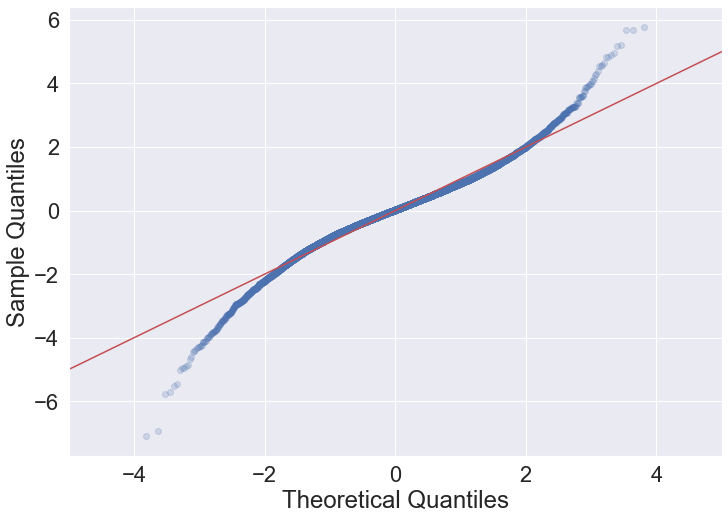

In [368]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model3_log.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [369]:
# We're still dealing with skew here... why

In [370]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train3 = model3_log.predict(X_train_out)
rmse_train3 = mse(y_train_log, y_hat_train3)**0.5
y_hat_test3 = model3_log.predict(X_test_out)
rmse_test3 = mse(y_test_log, y_hat_test3)**0.5
print(f'Train RMSE: {rmse_train3} \n Test RMSE: {rmse_test3}')
print('Percent change: ', round(((rmse_test3-rmse_train3)/rmse_train3)*100, 3))
print('Percent change (Test sets Base Model vs. Model2): ', round(((rmse_test3-rmse_test)/rmse_test)*100, 3))


Train RMSE: 0.17876840821905327 
 Test RMSE: 0.18300304628917824
Percent change:  2.369
Percent change (Test sets Base Model vs. Model2):  -100.0


In [371]:
# Those RMSEs seem improbable... maybe from collinearity which we will address next

### Model 4: Addressing Collinearity

In [372]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data_2std.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.5) & (coral.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.857486
"(cond__4, cond__3)",0.815930
"(sqft_living15, sqft_living)",0.743393
"(bathrooms, sqft_living)",0.723533
"(sqft_living15, sqft_above)",0.721484
"(bathrooms, sqft_above)",0.646387
"(sqft_living, price)",0.639734
"(bedrooms, sqft_living)",0.585192
"(price, sqft_living15)",0.579969


In [373]:
# Include price to determine which to keep
# Drop sqft_above, 

In [374]:
from sklearn.linear_model import LinearRegression

In [375]:
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

sqft_above = upHouse_data_2std.sqft_above.values.reshape(-1, 1)
sqft_living = upHouse_data_2std.sqft_living.values.reshape(-1, 1)
sqft_living15 = upHouse_data_2std.sqft_living15.values.reshape(-1, 1)
price = upHouse_data_2std.price.values.reshape(-1, 1)


regression_1.fit(sqft_above, price)
regression_2.fit(sqft_living, price)
regression_3.fit(sqft_living15, price)

# Make predictions using the testing set
pred_1 = regression_1.predict(sqft_above)
pred_2 = regression_2.predict(sqft_living)
pred_3 = regression_2.predict(sqft_living15)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[[164.70243184]]
[[179.82941853]]
[[205.87981237]]


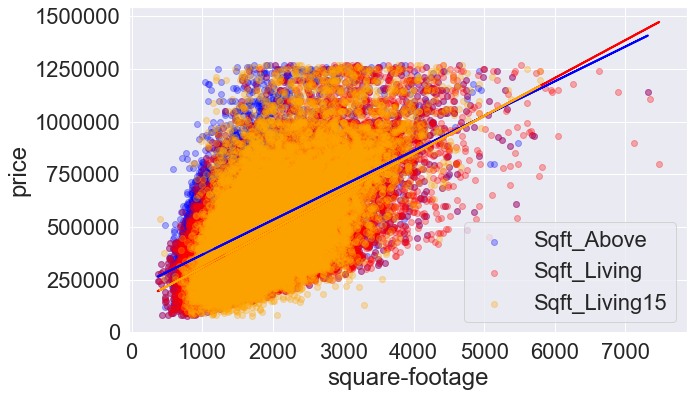

In [376]:
plt.figure(figsize=(10,6))

plt.scatter(sqft_above, upHouse_data_2std.price,  color='blue', alpha=0.3, label = 'Sqft_Above')
plt.scatter(sqft_living, upHouse_data_2std.price,  color='red', alpha=0.3, label = 'Sqft_Living')
plt.scatter(sqft_living15, upHouse_data_2std.price,  color='orange', alpha=0.3, label = 'Sqft_Living15')

plt.plot(sqft_above, pred_1, color='blue', linewidth=2)
plt.plot(sqft_living, pred_2, color='red', linewidth=2)
plt.plot(sqft_living15, pred_3, color='orange', linewidth=2)
plt.ylabel('price')
plt.xlabel('square-footage')
plt.legend();

In [377]:
X_interact_train = X_train_out.copy()
X_interact_test = X_test_out.copy()
X_interact_train['sqft_living-above'] = X_train_out['sqft_above'] * X_train_out['sqft_living']
X_interact_test['sqft_living-above'] = X_test_out['sqft_above'] * X_test_out['sqft_living']
X_interact_train.drop(columns=['sqft_living', 'sqft_above', 'sqft_living15'], inplace=True)
X_interact_test.drop(columns=['sqft_living', 'sqft_above', 'sqft_living15'], inplace=True)

In [378]:
print(len(X_interact_train))
len(X_interact_test)

14529


6227

In [379]:
training_model(feat_cols, outcome, y_train_log, X_interact_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     753.0
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:34:33   Log-Likelihood:                 3588.3
No. Observations:               14529   AIC:                            -6989.
Df Residuals:                   14435   BIC:                            -6276.
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -43.3019      8.845     -4.895      0.000     -60.640     -25.964
bedrooms              0.0123      0.002      5.624      0.000       0.008       0.017
bathrooms             0.0561      0.004     14.543      0.000       0.049       0.064
floors               -0.0211      0.005     -4.607      0.000      -0.030      -0.012
waterfront            0.3550      0.031     11.334      0.000       0.294       0.416
view                  0.0687      0.003     25.990      0.000       0.064       0.074
sqft_basement      5.522e-05   4.92e-06     11.230      0.000    4.56e-05    6.49e-05
yr_built             -0.0012   9.49e-05    -12.583      0.000      -0.001      -0.001
renovated             0.0514      0.010      5.298      0.000       0.032       0.070
lat                   0.6396      0.091      7.029      0.000       0.461       0.818
long                 -0.2244      0.065     -3.427      0.001      -0.353      -0.096
cond__2               0.0662      0.046      1.432      0.152      -0.024       0.157
cond__3               0.1837      0.043      4.262      0.000       0.099       0.268
cond__4               0.2235      0.043      5.184      0.000       0.139       0.308
cond__5               0.2772      0.043      6.390      0.000       0.192       0.362
grade__4             -0.4283      0.196     -2.187      0.029      -0.812      -0.044
grade__5             -0.3533      0.191     -1.851      0.064      -0.727       0.021
grade__6             -0.2122      0.190     -1.115      0.265      -0.585       0.161
grade__7             -0.0503      0.190     -0.264      0.792      -0.423       0.323
grade__8              0.0885      0.190      0.464      0.642      -0.285       0.462
grade__9              0.2158      0.191      1.132      0.257      -0.158       0.589
grade__10             0.2349      0.191      1.232      0.218      -0.139       0.609
grade__11             0.1964      0.191      1.026      0.305      -0.179       0.572
grade__12             0.1998      0.209      0.956      0.339      -0.210       0.609
grade__13          -3.31e-16   1.41e-15     -0.235      0.815    -3.1e-15    2.44e-15
zipcode__98002       -0.0385      0.021     -1.865      0.062      -0.079       0.002
zipcode__98003       -0.0326      0.018     -1.776      0.076      -0.069       0.003
zipcode__98004        0.8811      0.035     25.169      0.000       0.813       0.950
zipcode__98005        0.5806      0.036     16.289      0.000       0.511       0.650
zipcode__98006        0.4944      0.029     16.838      0.000       0.437       0.552
zipcode__98007        0.4712      0.037     12.728      0.000       0.399       0.544
zipcode__98008        0.4561      0.035     12.993      0.000       0.387       0.525
zipcode__98010        0.3241      0.031     10.578      0.000       0.264

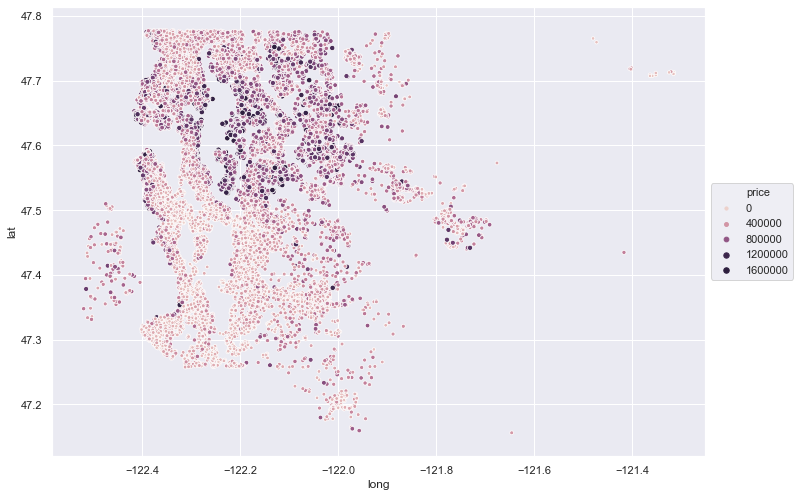

In [380]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(upHouse_data_2std.long, upHouse_data_2std.lat, hue=upHouse_data_2std.price, size=upHouse_data_2std.price,
    sizes=(10, 30))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);

In [381]:
bins = [0,1,2,3,4,5,6,7,8]
upHouse_data_2std['bathroom_bins'] = pd.cut(upHouse_data_2std['bathrooms'], bins,include_lowest = True)

upHouse_data_2std.head()

C:\Users\murra\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,sqft_above,sqft_basement,yr_built,...,zipcode__98148,zipcode__98155,zipcode__98166,zipcode__98168,zipcode__98177,zipcode__98178,zipcode__98188,zipcode__98198,zipcode__98199,bathroom_bins
0,221900.0,3,1.00,1180,1.0,0.0,0.0,1180,0.0,1955,...,0,0,0,0,0,1,0,0,0,"(-0.001, 1.0]"
1,538000.0,3,2.25,2570,2.0,0.0,0.0,2170,400.0,1951,...,0,0,0,0,0,0,0,0,0,"(2.0, 3.0]"
2,180000.0,2,1.00,770,1.0,0.0,0.0,770,0.0,1933,...,0,0,0,0,0,0,0,0,0,"(-0.001, 1.0]"
3,604000.0,4,3.00,1960,1.0,0.0,0.0,1050,910.0,1965,...,0,0,0,0,0,0,0,0,0,"(2.0, 3.0]"
4,510000.0,3,2.00,1680,1.0,0.0,0.0,1680,0.0,1987,...,0,0,0,0,0,0,0,0,0,"(1.0, 2.0]"


In [382]:
upHouse_data_2std['bathroom_bins'] = upHouse_data_2std['bathroom_bins'].cat.codes


C:\Users\murra\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [383]:
upHouse_data_2std['bathroom_bins'].value_counts()

2    9087
1    6394
0    3924
3    1233
4     107
5       8
6       2
7       1
Name: bathroom_bins, dtype: int64

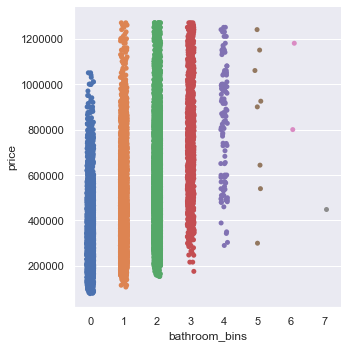

In [384]:
sns.catplot(x="bathroom_bins", y="price", data=upHouse_data_2std);

In [385]:
upHouse_data_2std = pd.concat([upHouse_data_2std,pd.get_dummies(upHouse_data_2std['bedrooms'], prefix='bedroom', drop_first=True)],axis=1).drop(['bedrooms'],axis=1)

In [386]:
upHouse_data_2std.head()

,price,bathrooms,sqft_living,floors,waterfront,view,sqft_above,sqft_basement,yr_built,renovated,...,bedroom_3,bedroom_4,bedroom_5,bedroom_6,bedroom_7,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33
0,221900.0,1.00,1180,1.0,0.0,0.0,1180,0.0,1955,0,...,1,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,2.0,0.0,0.0,2170,400.0,1951,1,...,1,0,0,0,0,0,0,0,0,0
2,180000.0,1.00,770,1.0,0.0,0.0,770,0.0,1933,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,1.0,0.0,0.0,1050,910.0,1965,0,...,0,1,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,1.0,0.0,0.0,1680,0.0,1987,0,...,1,0,0,0,0,0,0,0,0,0


In [387]:
upHouse_data_2std = pd.concat([upHouse_data_2std,pd.get_dummies(upHouse_data_2std['floors'], prefix='floors', drop_first=True)],axis=1).drop(['floors'],axis=1)

upHouse_data_2std.head(10)

,price,bathrooms,sqft_living,waterfront,view,sqft_above,sqft_basement,yr_built,renovated,lat,...,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,221900.0,1.00,1180,0.0,0.0,1180,0.0,1955,0,47.5112,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,0.0,0.0,2170,400.0,1951,1,47.7210,...,0,0,0,0,0,0,1,0,0,0
2,180000.0,1.00,770,0.0,0.0,770,0.0,1933,0,47.7379,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,0.0,0.0,1050,910.0,1965,0,47.5208,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,0.0,0.0,1680,0.0,1987,0,47.6168,...,0,0,0,0,0,0,0,0,0,0
5,1230000.0,4.50,5420,0.0,0.0,3890,1530.0,2001,0,47.6561,...,0,0,0,0,0,0,0,0,0,0
6,257500.0,2.25,1715,0.0,0.0,1715,0.0,1995,0,47.3097,...,0,0,0,0,0,0,1,0,0,0
7,291850.0,1.50,1060,0.0,0.0,1060,0.0,1963,0,47.4095,...,0,0,0,0,0,0,0,0,0,0
8,229500.0,1.00,1780,0.0,0.0,1050,730.0,1960,0,47.5123,...,0,0,0,0,0,0,0,0,0,0
9,323000.0,2.50,1890,0.0,0.0,1890,0.0,2003,0,47.3684,...,0,0,0,0,0,0,1,0,0,0


In [388]:
print(upHouse_data_2std.columns)

Index(['price', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'sqft_above',
       'sqft_basement', 'yr_built', 'renovated', 'lat',
       ...
       'bedroom_8', 'bedroom_9', 'bedroom_10', 'bedroom_11', 'bedroom_33',
       'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5'],
      dtype='object', length=112)


In [389]:
upHouse_data_2std['sqft_basement'] = upHouse_data_2std.sqft_basement.apply(lambda x: 1 if x > 0 else 0)


In [390]:
upHouse_data_2std.head()

,price,bathrooms,sqft_living,waterfront,view,sqft_above,sqft_basement,yr_built,renovated,lat,...,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,221900.0,1.00,1180,0.0,0.0,1180,0,1955,0,47.5112,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,0.0,0.0,2170,1,1951,1,47.7210,...,0,0,0,0,0,0,1,0,0,0
2,180000.0,1.00,770,0.0,0.0,770,0,1933,0,47.7379,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,0.0,0.0,1050,1,1965,0,47.5208,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,0.0,0.0,1680,0,1987,0,47.6168,...,0,0,0,0,0,0,0,0,0,0


In [391]:

upHouse_data_2std.rename(columns = {"sqft_basement":"basement"}, inplace=True)

upHouse_data_2std.head()

,price,bathrooms,sqft_living,waterfront,view,sqft_above,basement,yr_built,renovated,lat,...,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,221900.0,1.00,1180,0.0,0.0,1180,0,1955,0,47.5112,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,0.0,0.0,2170,1,1951,1,47.7210,...,0,0,0,0,0,0,1,0,0,0
2,180000.0,1.00,770,0.0,0.0,770,0,1933,0,47.7379,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,0.0,0.0,1050,1,1965,0,47.5208,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,0.0,0.0,1680,0,1987,0,47.6168,...,0,0,0,0,0,0,0,0,0,0


In [392]:
upHouse_data_2std.describe()

,price,bathrooms,sqft_living,waterfront,view,sqft_above,basement,yr_built,renovated,lat,...,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
count,2.075600e+04,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,...,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000,20756.000000
mean,4.877262e+05,2.065451,1998.126277,0.002987,0.184477,1725.686548,0.375169,1970.862160,0.031268,47.557786,...,0.000434,0.000193,0.000145,0.000048,0.000048,0.089564,0.370543,0.005781,0.027847,0.000289
std,2.244543e+05,0.718717,798.485446,0.054574,0.666890,744.431597,0.484178,29.209278,0.174045,0.140381,...,0.020819,0.013881,0.012022,0.006941,0.006941,0.285564,0.482962,0.075818,0.164539,0.017000
min,7.800000e+04,0.500000,370.000000,0.000000,0.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.170000e+05,1.500000,1407.250000,0.000000,0.000000,1180.000000,0.000000,1951.000000,0.000000,47.462900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.400000e+05,2.250000,1870.000000,0.000000,0.000000,1530.000000,0.000000,1974.000000,0.000000,47.568200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.132750e+05,2.500000,2460.000000,0.000000,0.000000,2130.000000,1.000000,1996.000000,0.000000,47.679400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.270000e+06,7.500000,7480.000000,1.000000,4.000000,7320.000000,1.000000,2015.000000,1.000000,47.777600,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [404]:
outcome = 'price'
feat_cols = list(upHouse_data_2std.columns)
feat_cols.remove(outcome)

In [405]:
X_out = upHouse_data_2std[feat_cols]
y_out = upHouse_data_2std['price']

In [406]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size = 0.30, random_state = 117)

In [407]:
X_train_out = sm.add_constant(X_train_out)
X_test_out = sm.add_constant(X_test_out)

In [408]:
y_train_log = np.log(y_train_out)
y_test_log = np.log(y_test_out)

In [409]:
training_model(feat_cols, outcome, y_train_log, X_train_out)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     746.4
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:24:44   Log-Likelihood:                 4509.9
No. Observations:               14529   AIC:                            -8800.
Df Residuals:                   14419   BIC:                            -7966.
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -41.5132      8.326     -4.986      0.000     -57.834     -25.193
bathrooms          0.0160      0.009      1.847      0.065      -0.001       0.033
sqft_living        0.0001   7.16e-06     15.642      0.000    9.79e-05       0.000
waterfront         0.3776      0.029     12.823      0.000       0.320       0.435
view               0.0586      0.003     23.218      0.000       0.054       0.064
sqft_above         0.0001   7.93e-06     14.612      0.000       0.000       0.000
basement           0.0356      0.006      6.154      0.000       0.024       0.047
yr_built          -0.0005   9.61e-05     -5.271      0.000      -0.001      -0.000
renovated          0.0690      0.009      7.523      0.000       0.051       0.087
lat                0.5935      0.085      6.943      0.000       0.426       0.761
long              -0.2151      0.062     -3.490      0.000      -0.336      -0.094
sqft_living15   7.978e-05   4.22e-06     18.922      0.000    7.15e-05     8.8e-05
cond__2            0.0799      0.043      1.838      0.066      -0.005       0.165
cond__3            0.1894      0.041      4.673      0.000       0.110       0.269
cond__4            0.2326      0.041      5.734      0.000       0.153       0.312
cond__5            0.2890      0.041      7.082      0.000       0.209       0.369
grade__4          -0.4697      0.184     -2.551      0.011      -0.831      -0.109
grade__5          -0.4401      0.180     -2.448      0.014      -0.793      -0.088
grade__6          -0.3414      0.179     -1.903      0.057      -0.693       0.010
grade__7          -0.2318      0.179     -1.292      0.197      -0.584       0.120
grade__8          -0.1382      0.180     -0.770      0.441      -0.490       0.214
grade__9          -0.0512      0.180     -0.285      0.776      -0.403       0.301
grade__10         -0.0328      0.180     -0.182      0.855      -0.385       0.320
grade__11         -0.0426      0.181     -0.236      0.814      -0.396       0.311
grade__12         -0.0793      0.197     -0.403      0.687      -0.465       0.307
grade__13      -1.316e-15   2.52e-15     -0.523      0.601   -6.25e-15    3.62e-15
zipcode__98002    -0.0230      0.019     -1.188      0.235      -0.061       0.015
zipcode__98003    -0.0201      0.017     -1.162      0.245      -0.054       0.014
zipcode__98004     0.8806      0.033     26.718      0.000       0.816       0.945
zipcode__98005     0.5783      0.034     17.258      0.000       0.513       0.644
zipcode__98006     0.4960      0.028     17.954      0.000       0.442       0.550
zipcode__98007     0.4987      0.035     14.321      0.000       0.430       0.567
zipcode__98008     0.4827      0.033     14.625      0.000       0.418       0.547
zipcode__98010     0.3097      0.029     10.755      0.000       0.253       0.366
zipcode__980

In [410]:
model5_log = sm.OLS(y_train_log, X_train_out).fit()

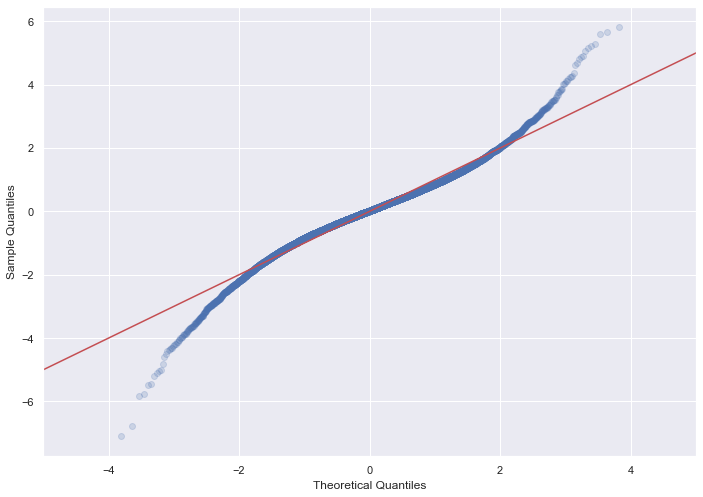

In [412]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model5_log.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [413]:
y_hat_train5 = model5_log.predict(X_train_out)
rmse_train5 = mse(y_train_log, y_hat_train5)**0.5
y_hat_test5 = model5_log.predict(X_test_out)
rmse_test5 = mse(y_test_log, y_hat_test5)**0.5
print(f'Train RMSE: {rmse_train5} \n Test RMSE: {rmse_test5}')
print('Percent change: ', round(((rmse_test5-rmse_train5)/rmse_train5)*100, 3))
print('Percent change (Test sets Model3 vs. Model5): ', round(((rmse_test5-rmse_test3)/rmse_test3)*100, 3))

Train RMSE: 0.17740023539736272 
 Test RMSE: 0.18226675123042727
Percent change:  2.743
Percent change (Test sets Model3 vs. Model5):  -0.402
